In [86]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [87]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [88]:
train_path = glob("./cityscapes_data/train/*")
valid_path = glob("./cityscapes_data/val/*")

In [89]:
# fig,ax = plt.subplots(5,2,figsize=(10,30))
# for i in range(5):
#     img = plt.imread(train_path[i])
#     ax[i][0].imshow(img[:,:256])
#     ax[i][1].imshow(img[:,256:])

In [90]:
train_dataset = []
validation_dataset = []

In [91]:
class MyDataset(Dataset):

    def __init__(self, images_path, transform_img=None, transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):

        img = plt.imread(self.images_path[idx])
        image, label = img[:, : int(img.shape[1] / 2)], img[:, int(img.shape[1] / 2) :]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [92]:
mytransformsImage = transform.Compose(
    [
        transform.ToTensor(),
        # transform.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transform.RandomHorizontalFlip(p=0.9),
    ]
)

mytransformsLabel = transform.Compose(
    [
        transform.ToTensor(),
    ]
)

In [93]:
# train dataset
traindata = MyDataset(train_path, mytransformsImage, mytransformsLabel)
# val dataset
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)

In [94]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata, batch_size)
vaild_loader = DataLoader(valdata, 1)

In [95]:
"""
    This is a helper function.
    This will help in ploting the masked got from the model.

"""


def show(img, output, label, denorm=False):
    img, output, label = img.cpu(), output.cpu(), label.cpu()
    fig, ax = plt.subplots(len(output), 3, figsize=(10, 10))

    for i in range(len(output)):
        if len(output) == 3:
            Img, Lab, act = img[i], output[i], label[i]
            Img, Lab, act = Img, Lab.detach().permute(1, 2, 0).numpy(), act
            ax[i][0].imshow(Img.permute(1, 2, 0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1, 2, 0))
        else:
            Img, Lab, act = img[i], output[i], label[i]
            Img, Lab, act = Img, Lab.detach().permute(1, 2, 0).numpy(), act
            ax[0].imshow(Img.permute(1, 2, 0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1, 2, 0))
    plt.show()

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [97]:
print(device)

cuda


In [98]:
"""

    This Module representes the individual horizontal conv block layers in the Unet Model.
    Conv() -> BatchNorm() -> ReLU() -> Conv() -> ReLU()

"""


class Convblock(nn.Module):

    def __init__(self, input_channel, output_channel, kernal=3, stride=1, padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernal, stride, padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, kernal),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.convblock(x)
        return x

In [99]:
# Encoder -> BottelNeck => Decoder
class UNet(nn.Module):

    def __init__(self, input_channel, retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel, 32)
        self.conv2 = Convblock(32, 64)
        self.conv3 = Convblock(64, 128)
        self.conv4 = Convblock(128, 256)
        self.neck = nn.Conv2d(256, 512, 3, 1)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 3, 2, 0, 1)
        self.dconv4 = Convblock(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 0, 1)
        self.dconv3 = Convblock(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 3, 2, 0, 1)
        self.dconv2 = Convblock(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 0, 1)
        self.dconv1 = Convblock(64, 32)
        self.out = nn.Conv2d(32, 3, 1, 1)
        self.retain = retain

    def forward(self, x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1, kernel_size=2, stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2, kernel_size=2, stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3, kernel_size=2, stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4, kernel_size=2, stride=2)

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4, upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4, croped], 1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3, upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3, croped], 1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2, upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2, croped], 1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1, upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1, croped], 1))
        # Output Layer
        out = self.out(dconv1)

        if self.retain == True:
            out = F.interpolate(out, list(x.shape)[2:])

        return out

    def crop(self, input_tensor, target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _, _, H, W = target_tensor.shape
        return transform.CenterCrop([H, W])(input_tensor)

In [100]:
model = UNet(3).float().to(device)

In [101]:
lr = 0.01
epochs = 30

In [102]:
# Choosing the loss function to be Mean Square Error Loss
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [103]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

In [104]:
train_loader

In [105]:
'''
    Traning the Model.
# '''
# img , label  = train_loader
# optimizer.zero_grad()
# img = img.to(device)
# label = label.to(device)
# output = model(img)
# loss = lossfunc(output,label)
# loss.backward()
# optimizer.step()
# trainloss+=loss.item()
# show(img, output, label)

'\n    Traning the Model.\n# '

100%|██████████| 744/744 [01:32<00:00,  8.04it/s]


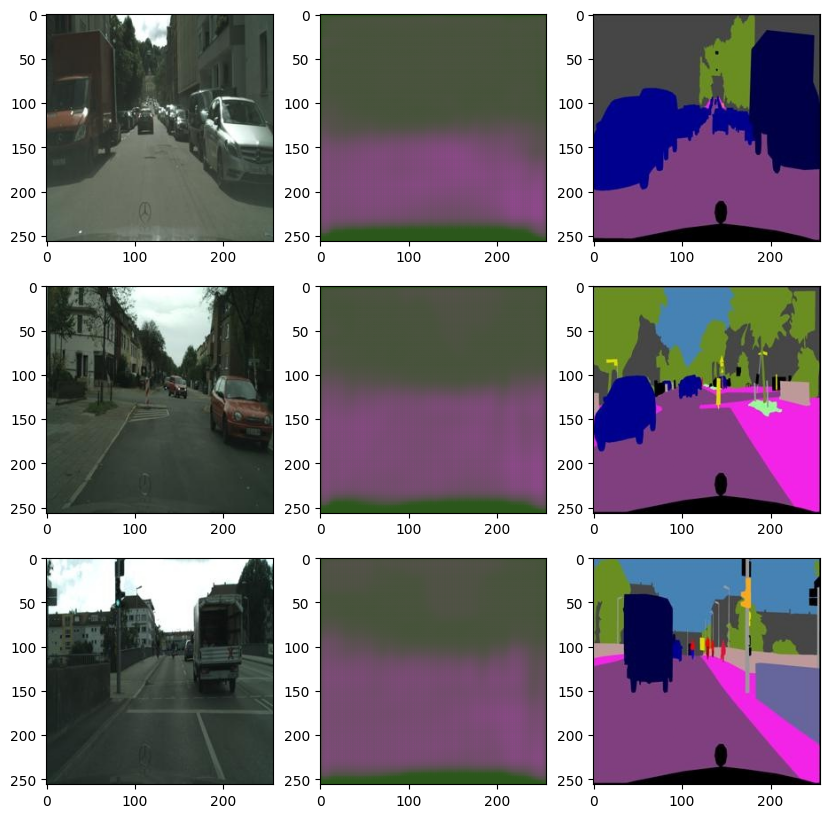

100%|██████████| 500/500 [00:06<00:00, 79.65it/s]


epoch : 0 ,train loss : 0.03871672252012837 ,valid loss : 0.03449608639255166 


 33%|███▎      | 247/744 [00:30<00:56,  8.86it/s]

In [106]:
for i in range(epochs):
    
    trainloss = 0
    valloss = 0
    
    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    
    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))    
  
    for img,label in tqdm(vaild_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()
        
    val_loss.append(valloss/len(vaild_loader))  
    
    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))